Attempting differential privacy - gaussian noise.

Google collab didnt allow me to install or use TFF library, so a simplified version is attempted below.

The gaussian noise is added to the Nodes

Aggreagtor recieves these noisey updates

The server aggregated using FedAvg to give an averaged noisey update

Averaged noisy update is added to the current global model's weights to get the new global model.

Here, Epsilon = 0.1, 1.0, 10.0, 50.0, in an attempt to try various attempts of high to moderate to low privacy


In [ ]:
# Import Libraries
!pip install tensorflow tensorflow-datasets matplotlib
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l2
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00


Memory Management Function

In [ ]:
# This section defines a function for managing resources, specifically TensorFlow memory.
def clear_tf_memory():
    # Defines the function 'clear_tf_memory', which requires no arguments.
    K.clear_session()
    # Clears the current TensorFlow graph. This releases resources associated with the previous graph, aiding in memory management.
    gc.collect()
    # Initiates garbage collection to reclaim unreferenced memory.
    if tf.config.list_physical_devices('GPU'):
    # Checks if physical GPU devices are available to TensorFlow.
        for gpu in tf.config.list_physical_devices('GPU'):
        # Iterates through each detected GPU device.
            tf.config.experimental.set_memory_growth(gpu, True)
            # Configures memory growth for the specific GPU. This setting attempts to allocate only the required GPU memory instead of pre-allocating all of it, which can help prevent out-of-memory errors when multiple processes share a GPU or during sequential model execution.
clear_tf_memory()
# Executes the 'clear_tf_memory' function to apply the defined memory management settings.

In [ ]:
# Define Global Variables
dataset_name = 'tf_flowers'
batch_size = 32
img_height = 224
img_width = 224
num_rounds = 5
epochs_per_client = 5
num_clients = 3
test_split = 0.1
local_val_split = 0.2
learning_rate = 0.0001
clipping_norm = 1.0  # Clipping norm for DP

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [ ]:
#Load and Preprocess Dataset
(raw_train, raw_val), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

val_data = raw_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.VHBGW8_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Function to Create Client Datasets
# Defines a function to prepare datasets for multiple clients in a federated learning setup.
# It takes the original dataset, number of clients, local validation split ratio, and global test split ratio as input.
def create_client_datasets(dataset, num_clients, local_val_split, test_split):
    # Shuffles the input dataset randomly.
    # Uses the dataset's size to set the buffer size for shuffling.
    # Sets a seed for reproducibility of the shuffling.
    shuffled_dataset = dataset.shuffle(buffer_size=tf.data.experimental.cardinality(dataset).numpy(), seed=42)
    # Gets the total number of elements in the shuffled dataset.
    dataset_size = tf.data.experimental.cardinality(shuffled_dataset).numpy()

    # Calculates the number of elements to be used for the global test set based on the test_split ratio.
    test_size = int(test_split * dataset_size)
    # Takes the first 'test_size' elements from the shuffled dataset to create the global test dataset.
    global_test_dataset = shuffled_dataset.take(test_size)
    # Skips the first 'test_size' elements to get the remaining dataset for client distribution.
    remaining_dataset = shuffled_dataset.skip(test_size)

    # Divides the remaining dataset into 'num_clients' shards (smaller datasets).
    # Each client will receive one shard.
    client_datasets = [
        remaining_dataset.shard(num_shards=num_clients, index=i) for i in range(num_clients)
    ]

    # Initializes an empty list to store the processed datasets for each client.
    processed_client_datasets = []
    # Loops through each client's raw dataset shard.
    for client_data in client_datasets:
        # Applies image resizing to the data in the current client's dataset shard.
        # It maps a function that resizes images to a specified height and width.
        # Uses automatic tuning for parallel processing.
        client_data = client_data.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y),
                                         num_parallel_calls=tf.data.AUTOTUNE)
        # Gets the number of elements in the current client's dataset after resizing.
        client_dataset_size = tf.data.experimental.cardinality(client_data).numpy()
        # Calculates the number of elements for the local validation set based on the local_val_split ratio.
        local_val_size = int(local_val_split * client_dataset_size)

        # Takes the first 'local_val_size' elements from the client's data for the local validation dataset.
        local_val_dataset = client_data.take(local_val_size)
        # Skips the first 'local_val_size' elements to get the remaining data for the local training dataset.
        local_train_dataset = client_data.skip(local_val_size)

        # Processes the local training dataset.
        local_train_dataset = local_train_dataset.map(
            # Applies data augmentation and MobileNetV2 preprocessing to the images.
            # Casts images to float32 before augmentation.
            lambda x, y: (
                tf.keras.applications.mobilenet_v2.preprocess_input(
                    data_augmentation(tf.cast(x, tf.float32))
                ),
                y
            ),
            # Uses automatic tuning for parallel processing.
            num_parallel_calls=tf.data.AUTOTUNE
        # Shuffles the training dataset with a buffer size of 1000.
        ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        # Batches the dataset into specified batch sizes.
        # Prefetches elements to improve performance.

        # Processes the local validation dataset.
        local_val_dataset = local_val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(
            batch_size).prefetch(tf.data.AUTOTUNE)
        # Applies a general preprocessing function to the validation dataset.
        # Uses automatic tuning for parallel processing.
        # Batches the dataset into specified batch sizes.
        # Prefetches elements to improve performance.
        # Appends the processed local training and validation datasets as a tuple to the list.
        processed_client_datasets.append((local_train_dataset, local_val_dataset))

    # Processes the global test dataset.
    global_test_dataset = global_test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(
        batch_size).prefetch(tf.data.AUTOTUNE)
    # Applies a general preprocessing function to the global test dataset.
    # Uses automatic tuning for parallel processing.
    # Batches the dataset into specified batch sizes.
    # Prefetches elements to improve performance.
    # Returns the list of processed client datasets and the processed global test dataset.
    return processed_client_datasets, global_test_dataset


In [ ]:
#Create Client Datasets and Global Test Set
client_datasets, global_test_data = create_client_datasets(raw_train, num_clients, local_val_split, test_split)

for i, (local_train_data, local_val_data) in enumerate(client_datasets):
    all_labels = []
    for _, labels in local_train_data.unbatch():
        all_labels.append(labels.numpy())

    class_counts = Counter(all_labels)
    print(f"Client {i + 1} Class Distribution: {class_counts}")

Client 1 Class Distribution: Counter({np.int64(0): 198, np.int64(2): 143, np.int64(3): 130, np.int64(4): 124, np.int64(1): 110})
Client 2 Class Distribution: Counter({np.int64(0): 174, np.int64(2): 150, np.int64(3): 134, np.int64(1): 130, np.int64(4): 117})
Client 3 Class Distribution: Counter({np.int64(0): 176, np.int64(2): 141, np.int64(3): 138, np.int64(1): 127, np.int64(4): 123})


In [ ]:
#Function to Create Model
def create_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(5, activation='softmax', dtype='float32')
    ])
    return model

The Differential Privacy Parameters

Privacy budget (epsilon). Lower values mean more privacy.


Clipping norm for gradients to bound sensitivity


Noise multiplier (sigma). Related to epsilon and sensitivity.

For Gaussian mechanism, sigma >= sqrt(2*ln(1/delta)) * sensitivity / epsilon

Assuming delta is small (e.g., 1/n_train), we can simplify for illustration.

noise_multiplier = 0.1  # Adjust this based on epsilon and clipping_norm

In [ ]:
# Function to perform Federated Learning with Differential Privacy
def federated_learning_with_dp(epsilon):
    global global_model
    global_model = create_model()
    global_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

    client_metrics = {
        'train_accuracy': {i: [] for i in range(num_clients)},
        'train_loss': {i: [] for i in range(num_clients)},
        'val_accuracy': {i: [] for i in range(num_clients)},
        'val_loss': {i: [] for i in range(num_clients)},
    }
    global_accuracies = []
    global_losses = []

    noise_multiplier = clipping_norm / epsilon  # Sensitivity is bounded by the clipping norm for per-example gradients

    for round_num in range(num_rounds):
        print(f"\n=== Round {round_num + 1}/{num_rounds} ===") # Removed epsilon here
        client_updates = []

        print("[1/4] Broadcasting global model...")
        global_weights = global_model.get_weights()

        print("[2/4] Clients training locally...")
        for client_id in range(num_clients):
            print(f"\nClient {client_id + 1}:")

            local_model = create_model()
            local_model.set_weights(global_weights)
            local_model.compile(
                optimizer=Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

           # Get the local training and validation data for the current client.
# client_datasets is a list of datasets, one for each client.
local_train_data, local_val_data = client_datasets[client_id]

            # Start a TensorFlow GradientTape to record operations for automatic differentiation.
            # persistent=True allows multiple gradient calculations within the same tape context.
            with tf.GradientTape(persistent=True) as tape:
                # Loop through batches of images and labels in the local training data.
                for images, labels in local_train_data:
                    # Get predictions from the local model for the current batch of images.
                    predictions = local_model(images)
                    # Calculate the loss between the true labels and the model's predictions.
                    # Using sparse_categorical_crossentropy for classification tasks.
                    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
                # Calculate the gradients of the loss with respect to the local model's trainable variables.
                gradients = tape.gradient(loss, local_model.trainable_variables)

            # Clip the calculated gradients by their norm to prevent exploding gradients.
            # helps stabilize training.
            clipped_gradients = [tf.clip_by_norm(grad, clipping_norm) for grad in gradients]

            # Add Gaussian noise to the clipped gradients for differential privacy.
            noisy_gradients = []
            # Loop through each clipped gradient.
            for grad in clipped_gradients:
                # Generate random normal noise with the same shape as the gradient.
                # The standard deviation of the noise is scaled by a noise_multiplier and the clipping_norm.
                noise = tf.random.normal(shape=grad.shape, mean=0.0, stddev=noise_multiplier * clipping_norm) # Scale noise by clipping norm
                # Add the generated noise to the current clipped gradient.
                noisy_gradients.append(grad + noise)

            # Get the optimizer associated with the local model.
            optimizer = local_model.optimizer
            # Apply the noisy gradients to update the local model's trainable variables using the optimizer.
            # zip pairs the noisy gradients with the corresponding trainable variables.
            optimizer.apply_gradients(zip(noisy_gradients, local_model.trainable_variables))


            history = local_model.fit(
                local_train_data,
                validation_data=local_val_data,
                epochs=epochs_per_client,
                callbacks=[reduce_lr],
                verbose=1
            )

            # Record the training and validation metrics from the training history.
            client_metrics['train_accuracy'][client_id].append(history.history['accuracy'][-1])
            client_metrics['train_loss'][client_id].append(history.history['loss'][-1])
            client_metrics['val_accuracy'][client_id].append(history.history['val_accuracy'][-1])
            client_metrics['val_loss'][client_id].append(history.history['val_loss'][-1])

            # Get the weights of the local model after training.
            local_weights = local_model.get_weights()
            # Calculate the update (difference) between the local weights and the global weights.
            # This update will be sent back to the server for aggregation.
            update = [lw - gw for lw, gw in zip(local_weights, global_weights)]
            # Add the calculated update to a list of client updates.
            client_updates.append(update)

            # Delete the local model to free up memory.
            del local_model
            # Delete the GradientTape to release resources.
            del tape


        # Aggregate the client updates (averaging)
        print("\n[3/4] Aggregating client updates...")
        averaged_update = [np.zeros_like(global_weight, dtype=np.float32) for global_weight in global_weights]
        for update in client_updates:
            for i in range(len(averaged_update)):
                averaged_update[i] += update[i]
        averaged_update = [au / num_clients for au in averaged_update]

        # Apply the aggregated update to the global model
        print("[4/4] Updating global model...")
        current_global_weights = global_model.get_weights()
        new_global_weights = [cw + au for cw, au in zip(current_global_weights, averaged_update)]
        global_model.set_weights(new_global_weights)

        # Evaluate the global model on the global test set
        loss, accuracy = global_model.evaluate(
            global_test_data,
            batch_size=batch_size,
            verbose=0
        )
        global_accuracies.append(accuracy)
        global_losses.append(loss)
        print(f"\nGlobal Model Test - Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}")

    return global_accuracies[-1] if global_accuracies else 0.0


--- Starting sweep for Epsilon: 0.10 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

=== Round 1/5 ===
[1/4] Broadcasting global model...
[2/4] Clients training locally...

Client 1:


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.2267 - loss: 6.5254 - val_accuracy: 0.4205 - val_loss: 5.5420 - learning_rate: 1.0000e-04
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.3385 - loss: 6.1253 - val_accuracy: 0.5398 - val_loss: 5.3692 - learning_rate: 1.0000e-04
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.4651 - loss: 5.6980 - val_accuracy: 0.6761 - val_loss: 5.1048 - learning_rate: 1.0000e-04
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.4602 - loss: 5.5804 - val_accuracy: 0.6989 - val_loss: 5.0334 - learning_rate: 1.0000e-04
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.5845 - loss: 5.2843 - val_accuracy: 0.7614 - val_loss: 4.7692 - learning_rate: 1.0000e-04

Client 2:
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.2766 - loss: 6.4639 - val_accuracy: 0.4773 - val_loss: 5.5158 - learning_rate: 1.0000e-04
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accu

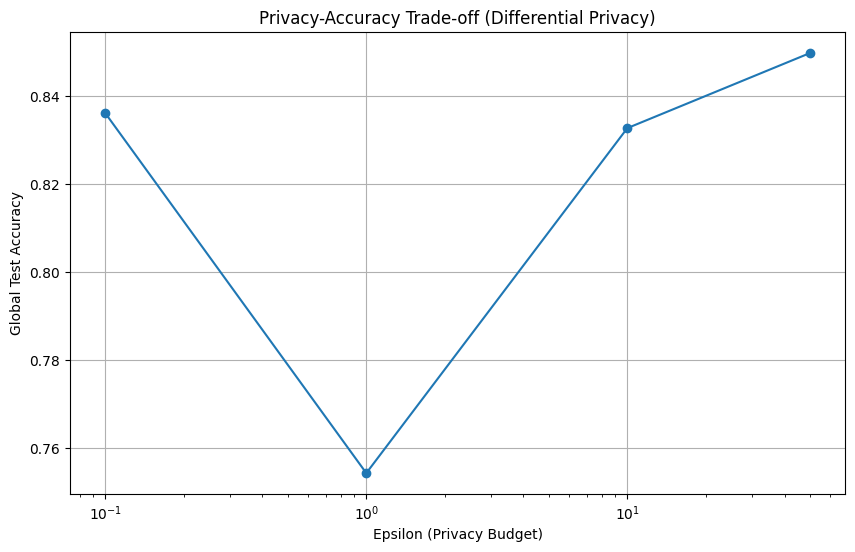

In [ ]:
# Define epsilon values to sweep
# This creates a list of different 'epsilon' values.
epsilon_values = [0.1, 1.0, 10.0, 50.0]
# Initialize a dictionary to store the results of the sweep.
# The keys will be the epsilon values, and the values will be the corresponding accuracy results.
sweep_results = {}

# Start a loop that goes through each epsilon value in the 'epsilon_values' list.
for epsilon in epsilon_values:
    # Print a message to the console indicating which epsilon value is currently being tested.
    # ":.2f" formats the epsilon value to two decimal places.
    print(f"\n--- Starting sweep for Epsilon: {epsilon:.2f} ---")
    # Call the 'federated_learning_with_dp' function.
    #  function is assumed to run a federated learning process with differential privacy applied, using the current 'epsilon' value.
    # It returns the resulting accuracy of the model.
    accuracy = federated_learning_with_dp(epsilon)
    # Store the returned accuracy in the 'sweep_results' dictionary, using the current epsilon value as the key.
    sweep_results[epsilon] = accuracy
    # Call the 'clear_tf_memory' function after each run.
    # This helps free up memory used by TensorFlow and the model before the next run starts with a different epsilon.
    clear_tf_memory()


# plt.semilogx is used because epsilon values are often better viewed on a logarithmic scale, especially when they vary widely.
# It plots the epsilon values (keys of sweep_results) on the x-axis (log scale) against the accuracy values (values of sweep_results) on the y-axis.
# 'marker='o'' adds circular markers at each data point.

# Plotting the sweep results
plt.figure(figsize=(10, 6))
plt.semilogx(list(sweep_results.keys()), list(sweep_results.values()), marker='o')
plt.title('Privacy-Accuracy Trade-off (Differential Privacy)')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Global Test Accuracy')
plt.grid(True)
plt.show()